# Building the SFR2 package

Steps to building the SFR2 package using:
1. DEM of surface
    - This will be used to set the elevation of the river bed and the slope of the river bed along each reach
2. Streamflow info, i.e. gaugings, any other data
    - This will be used to set inflow from Lake Eppalock dam and also to provide observations for model optimisation
3. Polyline of streams
    - This will be used to map the stream to grid and with the combination of the DEM to sort out the ordering from one reach to       the next

### Some assumptions that effect choice of SFR2 parameters:
Flux between surface and subsurface is saturated, i.e. we don't consider the unsaturated zone, or any options parameters associated with this in the SFR2 package.


### Data requirements:
As this package will be required for both a steady state and transient model we will need slightly different setups and parameters.

For the steady state 1a. will be specified as <code>REACHINPUT</code>, but for the transient model, 1a. will be specified as <code>REACHINPUT TRANSROUTE</code>

1b. <code>TABFILES NUMTAB MAXVAL</code>
    Input flows can be specified to segements using tabular data here. This will come from processing the flow data inline with     temporal setup of the model

1c. <code>NSTRM NSS NSFRPAR NPARSEG CONST DLEAK ISTCB1 ISTCB2 {ISFROPT} {NSTRAIL} {ISUZN} {NSFRSETS} {IRTFLG} {NUMTIM} {WEIGHT} {FLWTOL}</code>



The main bits to put together for this outside of the flags and solver options are:
1. reach_data
    - <code>k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1 </code>
    - <code>k,i,j</code> come from mapping a polyline to the grid
    - <code>iseg</code> segments have to be defined, which we can do for each reach between gauges.
    - <code>rchlen</code> comes from the mapping
    - <code>strtop</code> is the streambed elevation
    - <code>strthick</code> is the thickness of the streambed
    - <code>strhc1</code> is the hydraulic conductivity of the streambed.
2. segment_data
    - <code>nseg,icalc,outseg,iupseg,nstrpts,flow,runoff,etsw,pptsw,roughch,roughbk,cdpth,fdpth,awdth,bwdth,width1,width2</code>
    - nseg
    
3. channel_geometry_data,
4. channel_flow_data,
5. dataset_5,



In [1]:
import os
import subprocess
import datetime
from osgeo import gdal, osr, ogr
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Processing the surface DEM 
This is to translate from the much finer DEM to the grid of the model and rebin the raster pixels using the minimum value

In [2]:
from HydroModelBuilder.GISInterface.GDALInterface import reproject

In [3]:
# Test for raster reprojection
pixel_spacing = 1000
epsg_from = None
epsg_to = 28355

Proj_CS = osr.SpatialReference()
# 28355 is the code for gda94 mga zone 55;
# http://spatialreference.org/ref/epsg/gda94-mga-zone-55/
Proj_CS.ImportFromEPSG(28355)
target_srs = Proj_CS.ExportToWkt()

In [4]:
def get_extent(fname):
    grid_data = ogr.Open(fname, 0)
    grid_layer = grid_data.GetLayer(0)
    srs = grid_layer.GetSpatialRef()
    print(grid_layer.GetGeomType())
    featureDefn = grid_layer.GetLayerDefn()        
    return grid_layer.GetExtent()

grid_file = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\SW\Farm\structured_model_grid_5000m.shp"
xmin, xmax, ymin, ymax = get_extent(grid_file)
bounds = xmin, xmax, ymin, ymax

3


In [5]:
def create_centroids(x_pixel, y_pixel, bounds):
    xmin, xmax, ymin, ymax = bounds
    cols = int((xmax - xmin)/x_pixel)
    rows = int((ymax - ymin)/y_pixel)
    x = np.linspace(xmin + x_pixel / 2.0, xmax - x_pixel / 2.0, cols)
    y = np.linspace(ymax - y_pixel / 2.0, ymin + y_pixel / 2.0, rows)
    X, Y = np.meshgrid(x, y)

    centroid2mesh2Dindex = {}
    mesh2centroid2Dindex = {}
    for row in xrange(rows):
        for col in xrange(cols):
            centroid2mesh2Dindex[(x[col], y[row])] = [row, col]
            mesh2centroid2Dindex[(row, col)] = [x[col], y[row]]
        # end for
    # end for
    return centroid2mesh2Dindex, mesh2centroid2Dindex

centroids = create_centroids(pixel_spacing, pixel_spacing, bounds)    

In [6]:
surf_file = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\Surface_DEM_Geoscience_Australia\CampDEM1s_1755033\CampDEM1s.tif" #r"C:\Workspace\part0075\MDB modelling\ESRI_GRID_raw\ESRI_GRID\sur_1t"
sur_min_file = r"C:\Workspace\part0075\MDB modelling\testbox\data_build\CampDEM1s_reproj.tif"
resample_method = "min"

In [7]:

# -te xmin ymin xmax ymax # Set bounds
# -tr xres yres #set output file resolution (in target georeferenced units)
# -r resampling_method  # includes min

#command = "gdalwarp -overwrite -t_srs EPSG:{} ".format(epsg_to) + " -tr {} {} ".format(str(pixel_spacing), str(pixel_spacing)) +  " -te " + " {0} {1} {2} {3} ".format(xmin, ymin, xmax, ymax) + \
#         '"' + surf_file + '" "' + sur_min_file + '" -r {}'.format(resample_method)
command = "gdalwarp -overwrite -t_srs EPSG:{} ".format(epsg_to) + " -te " + " {0} {1} {2} {3} ".format(xmin, ymin, xmax, ymax) + \
         '"' + surf_file + '" "' + sur_min_file + '" -r {}'.format(resample_method)

try:
    print(subprocess.check_output(command, shell=True))
except subprocess.CalledProcessError as e:
    print(e)


0...10...20...30...40...50...60...70...80...90...100 - done.



In [12]:
raster = gdal.Open(sur_min_file)
raster_array = raster.ReadAsArray()
raster_band = raster.GetRasterBand(1)
help(raster_band)
raster_array_mask = np.ma.masked_equal(raster_array, raster_array.min())
raster = None

Help on Band in module osgeo.gdal object:

class Band(MajorObject)
 |  Proxy of C++ GDALRasterBandShadow class.
 |  
 |  Method resolution order:
 |      Band
 |      MajorObject
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  Checksum(self, *args, **kwargs)
 |      Checksum(Band self, int xoff=0, int yoff=0, int * xsize=None, int * ysize=None) -> int
 |  
 |  ComputeBandStats(self, *args)
 |      ComputeBandStats(Band self, int samplestep=1)
 |  
 |  ComputeRasterMinMax(self, *args)
 |      ComputeRasterMinMax(Band self, int approx_ok=0)
 |  
 |  ComputeStatistics(self, *args)
 |      ComputeStatistics(Band self, bool approx_ok, GDALProgressFunc callback=0, void * callback_data=None) -> CPLErr
 |  
 |  CreateMaskBand(self, *args)
 |      CreateMaskBand(Band self, int nFlags) -> CPLErr
 |  
 |  DeleteNoDataValue(self, *args)
 |      DeleteNoDataValue(Band self) -> CPLErr
 |  
 |  Fill(self, *args)
 |      Fill(Band self, double real_fill, double imag_fill=0.0) -> CPL

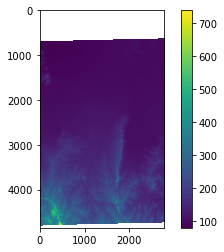

In [9]:
im = plt.imshow(raster_array_mask)
plt.colorbar()

## Getting the river shapefile to help with the build

In [10]:
riv_shapefile = r"C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv.shp" #r"C:\Workspace\part0075\MDB modelling\Campaspe_data\SW\Farm\test_model.shp" # 

In [11]:
def multipolygon(file_in, file_out):
    shp1 = ogr.Open(file_in)
    layer1 = shp1.GetLayer(0)
    srs = layer1.GetSpatialRef()
    driver = ogr.GetDriverByName('ESRI Shapefile')
    dstshp = driver.CreateDataSource(file_out)
    dstlayer = dstshp.CreateLayer('mylayer', srs, geom_type=ogr.wkbMultiPolygon)
    mesh = ogr.Geometry(ogr.wkbMultiPolygon)
    try:
        for index, feat in enumerate(layer1): 
            #if index == 0:
                #print(dir(mesh))
            mesh.AddGeometry(feat.GetGeometryRef())
    except:
        print("Me no work")
        dstshp = None

    featureDefn = dstlayer.GetLayerDefn()        
    meshFeature = ogr.Feature(featureDefn)
    meshFeature.SetGeometry(mesh)
    dstlayer.CreateFeature(meshFeature)    
    meshFeature.Destroy
    dstshp.Destroy
    dstshp = None

In [12]:
grid_file_new = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\SW\Farm\structured_model_grid_5000m_multi.shp"
multipolygon(grid_file, grid_file_new)

Very relevant code that could improve speed on finding intersections: https://gis.stackexchange.com/questions/82935/ogr-layer-intersection

In [13]:
def vector2array(vector_fn, pixel_size, bounds):

    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_fn)
    source_layer = source_ds.GetLayer()
    source_srs = source_layer.GetSpatialRef()
    x_min, x_max, y_min, y_max = bounds

    # Create the destination data source
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    band = target_ds.GetRasterBand(1)

    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])
    band.SetNoDataValue(-99)

    # Read as array
    array = band.ReadAsArray()
    return array

In [14]:
river_array = vector2array(riv_shapefile, pixel_spacing, bounds)

In [15]:
river_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
def Testing():
    new_grid = ogr.Open(grid_file_new)
    new_grid_layer = new_grid.GetLayer(0)
    print(new_grid_layer.GetGeomType())

In [17]:
Testing()

3


In [18]:
fig = plt.figure(figsize=(20,10))
new_riv_array = np.ma.masked_array(raster_array, mask=np.logical_not(river_array))
im2 = plt.imshow(new_riv_array)
ax = im2.axes
if pixel_spacing == 5000:
    ax.set_xlim(4,11)
    ax.set_ylim(25, 6)
if pixel_spacing == 1000:
    ax.set_xlim(25,55)
    ax.set_ylim(125, 35)
if pixel_spacing == 100:
    ax.set_xlim(250,520)
    ax.set_ylim(900, 380)

plt.colorbar()

MaskError: Mask and data not compatible: data size is 13454596, mask size is 11200.

In [40]:
def mask2rowcolvec(array):
    rows, cols = array.shape
    vec = []
    for row in range(rows):
        for col in range(cols):
            if array.mask[row, col] == False:
                vec += [[row, col, array.data[row, col]]]
    return vec

In [41]:
riv_mask = np.logical_not(river_array)

In [42]:
riv_vec = mask2rowcolvec(new_riv_array)

NameError: name 'new_riv_array' is not defined

In [43]:
riv_vec

NameError: name 'riv_vec' is not defined

In [44]:
riv_bed = [[index * 5000, x[2]] for index, x in enumerate(riv_vec)]

NameError: name 'riv_vec' is not defined

In [45]:
plt.plot([x[0] for x in riv_bed], [x[1] for x in riv_bed])
plt.title("Automatic ordering of river cells")

NameError: name 'riv_bed' is not defined

In [46]:
new_riv = sorted(riv_vec, key=lambda x: x[2], reverse=False)

NameError: name 'riv_vec' is not defined

In [47]:
riv_bed = [[index * 5000, x[2]] for index, x in enumerate(new_riv)]

NameError: name 'new_riv' is not defined

In [48]:
plt.plot([x[0] for x in riv_bed], [x[1] for x in riv_bed])
plt.title("Reordering of river cells")

NameError: name 'riv_bed' is not defined

## Interrogating and manipulating river shapefile

In [49]:
def polyline_explore(poly_file):
    poly_ds = ogr.Open(poly_file)
    poly_layer = poly_ds.GetLayer()
    count = poly_layer.GetFeatureCount()
    print(count)
    points = {}
    points_all = []
    point_count = 0
    for index, feat in enumerate(poly_layer):
        geom = feat.GetGeometryRef()
        point_count += geom.GetPointCount()
        #print point_count
        if index in range(count) :#, 1, 2, 3, 4, 5, 6, 7, 8, 9]: # range(count): #
            points[index] = geom.GetPoints()
            points_all += geom.GetPoints()
        #points[index] = geom.GetPoints()

    for index in points.keys():
        #print(points[index])
        plt.scatter(x=[x[0] for x in points[index]], y=[x[1] for x in points[index]], label=str(index))
    plt.axes().set_aspect('equal', 'datalim')
    print(point_count)
    #plt.legend()
    return points_all, points

172
2672


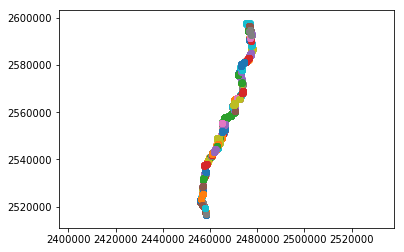

In [50]:
points, points_dict = polyline_explore(riv_shapefile)

In [51]:
points_dict

{0: [(2470643.773000002, 2561241.208999999),
  (2470717.2440000027, 2561336.5590000004)],
 1: [(2456605.9529, 2527758.408),
  (2456646.454099998, 2527873.903000001),
  (2456646.454099998, 2527924.9010000005),
  (2456620.9551, 2528031.3960000016),
  (2456631.4560000002, 2528095.892999999),
  (2456673.4570999965, 2528227.886),
  (2456743.958999999, 2528421.3779999986)],
 2: [(2460807.846000001, 2542806.8940000013),
  (2460809.7590000033, 2542809.6689999998)],
 3: [(2457481.9949999973, 2532324.2010000013),
  (2457547.9970000014, 2532441.1950000003),
  (2457644.0, 2532648.185899999),
  (2457666.501000002, 2532709.6829999983),
  (2457696.5019999966, 2532811.6799999997),
  (2457710.0029999986, 2532954.1739999987),
  (2457693.505099997, 2533069.6700999998),
  (2457669.5059999973, 2533153.666000001),
  (2457644.0059999973, 2533221.1631000005),
  (2457611.0069999993, 2533264.6609999985),
  (2457594.5069999993, 2533303.66),
  (2457539.0090000033, 2533521.1510000005),
  (2457494.0099000037, 25335

In [52]:
for key in points_dict.keys():
    points_dict[key] += [{'start':points_dict[key][0], 'end':points_dict[key][-1]}]

points_dict[0]                         

[(2470643.773000002, 2561241.208999999),
 (2470717.2440000027, 2561336.5590000004),
 {'end': (2470717.2440000027, 2561336.5590000004),
  'start': (2470643.773000002, 2561241.208999999)}]

In [53]:
point_merge = points_dict[0][0:-1]
for kar in points_dict.keys()[1:]:
    for key in points_dict.keys()[1:]:
        if points_dict[key][-1]['start'] == point_merge[-1]:
            point_merge += points_dict[key][0:-1] 
            continue
        # end if
        if points_dict[key][-1]['end'] == point_merge[0]:
            point_merge = points_dict[key][0:-1] + point_merge
            continue
        # end if    

In [54]:
from more_itertools import unique_everseen
point_merge2 = list(unique_everseen(point_merge))

In [55]:
print(len(point_merge), len(point_merge2))

(2672, 2501)


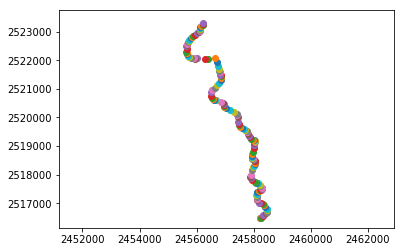

In [56]:
for index, point in enumerate(point_merge2[0:145]):
    #print(point)
    plt.scatter(x=[x[0] for x in [point]], y=[x[1] for x in [point]], label=str(index))
plt.axes().set_aspect('equal', 'datalim')        
#plt.legend()

In [57]:
input_shape = riv_shapefile
input_dir = "{}".format(os.path.sep).join(input_shape.split(os.path.sep)[0:-1])

print input_dir

output_shape = input_shape[:-4] + "_merge.shp"

coarsen = False

if coarsen:
    simplify = "-simplify 100"
else:
    simplify = ""
    
#command = 'ogr2ogr -overwrite "{}" "{}" '.format(output_shape, input_shape) + \
#    ' {} -dialect sqlite -sql "SELECT ST_Union(geometry) AS geometry FROM test_model"'.format(simplify) #, common_attribute from input GROUP BY common_attribute 

command = 'ogr2ogr -overwrite "{}" "{}" '.format(output_shape, input_shape) + \
    ' {} -dialect sqlite -sql "SELECT ST_Union(geometry) FROM test_model"'.format(simplify) #, common_attribute from input GROUP BY common_attribute 

#command = 'ogr2ogr -overwrite "{}" "{}" '.format(output_shape, input_shape) + \
#    ' {} -dialect sqlite -sql "SELECT ST_LineMerge(geometry) AS geometry FROM test_model"'.format(simplify) #, common_attribute from input GROUP BY common_attribute 

#command = 'ogr2ogr -overwrite -sql "SELECT b.geometry, n.geometry from test_model b, test_model2 n WHERE ST_INTERSECTS(b.geometry, n.geometry)" -dialect SQLITE "{}" "{}"'.format(output_shape, os.path.join(input_dir, "input.vrt"))
    
try:
    print(subprocess.check_output('ogrinfo "{}"'.format(input_shape), shell=True))
except subprocess.CalledProcessError as e:
    print(e)
    
    
try:
    print(subprocess.check_output(command, shell=True))
except subprocess.CalledProcessError as e:
    print(e)


C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways
INFO: Open of `C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv.shp'
      using driver `ESRI Shapefile' successful.
1: Campaspe_Riv (Line String)

Command 'ogr2ogr -overwrite "C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv_merge.shp" "C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv.shp"   -dialect sqlite -sql "SELECT ST_Union(geometry) FROM test_model"' returned non-zero exit status 1


In [58]:
# Function to convert linestring to list of points

def linestring2points(linestring):
    linestring = linestring.split("LINESTRING (")[1].split(")")[0].split(',')
    linestring = [[float(x.split(" ")[0]), float(x.split(" ")[1])] for x in linestring]
    print("called")
    return linestring
    
linestring2points("LINESTRING (279919.825526034 5918865.93727928,279919.909772995 5918866.00435057)")    

called


[[279919.825526034, 5918865.93727928], [279919.909772995, 5918866.00435057]]

In [59]:
########## Function to extract points from multi-linestring  ############

def polyline_explore2(poly_file):
    poly_ds = ogr.Open(poly_file)
    poly_layer = poly_ds.GetLayer()
    count = poly_layer.GetFeatureCount()
    points = {}
    points_all = []
    print(count)
    point_count = 0
    for index, feat in enumerate(poly_layer):
        geom = feat.GetGeometryRef()
        for geo in geom:
            points_all += linestring2points(geo.ExportToWkt())

    return points_all

#points2 = polyline_explore2(output_shape)

In [60]:
def smooth_poly(poly_file, smooth_factor=100):
    poly_out = poly_file.split(os.path.sep)[-1]
    poly_out = poly_out.split('.')[0]
    out_data_folder = "{}".format(os.path.sep).join(poly_file.split(os.path.sep)[0:-1])

    smth = os.path.join(out_data_folder, poly_out + '_smoothed.shp')
    smth = smth

    command = 'ogr2ogr -overwrite "{}" "{}" -simplify {}'.format(smth, poly_file, smooth_factor)
    try:
        subprocess.check_output(command, shell=True)  # , stdout=FNULL, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        print(e)

In [61]:
smooth_poly(output_shape)

Command 'ogr2ogr -overwrite "C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv_merge_smoothed.shp" "C:\Workspace\part0075\MDB modelling\testbox\input_data\Waterways\Campaspe_Riv_merge.shp" -simplify 100' returned non-zero exit status 1


In [62]:
def createLinestringFromPoints(points, file_in, file_out):
    shp1 = ogr.Open(file_in)
    layer1 = shp1.GetLayer(0)
    srs = layer1.GetSpatialRef()
    
    driver = ogr.GetDriverByName('ESRI Shapefile')
    dstshp = driver.CreateDataSource(file_out)
    dstlayer = dstshp.CreateLayer('mylayer', srs, geom_type=ogr.wkbLineString)

    line = ogr.Geometry(ogr.wkbLineString)
    for point in points:
        line.AddPoint(*point)

    featureDefn = dstlayer.GetLayerDefn()        
    lineFeature = ogr.Feature(featureDefn)
    lineFeature.SetGeometry(line)
    dstlayer.CreateFeature(lineFeature)    
    lineFeature.Destroy
    dstshp.Destroy
    dstshp = None    
        

In [63]:
ref = grid_file
line_file = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\SW\Farm\test_model_new.shp"
createLinestringFromPoints(point_merge, ref, line_file)

## River now merged to single line string

Use the river single linestring with kdtree to map the points to the nearest cell centroid. Make sure ordering of points starts at upstream end. Then do a check to make sure that the river only jumps to 1 adjacent cell and only crosses that cell once.

In [64]:
from scipy import spatial
def do_kdtree(model_mesh_points, points):
    mytree = spatial.cKDTree(model_mesh_points)
    dist, indexes = mytree.query(points)
    return indexes


Now to find the closest centroid to each point in the polyline 

In [65]:
model_mesh_points = np.array(centroids[0].keys())

points_array = np.array(point_merge2)

closest = do_kdtree(model_mesh_points, points_array)


In [66]:
closest

array([10513, 10513, 10513, ..., 10513, 10513, 10513])

In [67]:
centroids[0].keys()[closest[0]]

(326720.78720466746, 5900728.7338229213)

In [68]:
point2mesh_map = {}
for index, point in enumerate(points_array):
    point2mesh_map[tuple(list(point))] = centroids[0][tuple(model_mesh_points[closest[index]])]
    
point2mesh_map2 = []
for index, point in enumerate(points_array):
    point2mesh_map2 += [centroids[0][tuple(model_mesh_points[closest[index]])] ]   

In [69]:
point2mesh_map2

[[139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [139, 79],
 [13

In [70]:
list(point)


[2475403.7749999985, 2597851.0069999993]

To simplify the list generated we need to first remove duplicates when they occur in sequence OR when they occur. That is we don't allow the river to wind back into the same cell as this can't be handled by SFR at this point.

EDIT: Actually this is fine, except you just need to separate the lengths in this case.

In [71]:
amalg_riv_points = []
amalg_riv_points_collection = {}
counter = 0
for index, point in enumerate(point2mesh_map2):
    if index == 0:
        amalg_riv_points += [point]
        try:
            amalg_riv_points_collection[counter] += [point_merge2[index]]
        except:
            amalg_riv_points_collection[counter] = [point_merge2[index]]
        continue
    elif point != amalg_riv_points[-1]:
        amalg_riv_points += [point]
        counter += 1
        try:
            amalg_riv_points_collection[counter] += [point_merge2[index]]
        except:
            amalg_riv_points_collection[counter] = [point_merge2[index]]
    else:
        try:
            amalg_riv_points_collection[counter] += [point_merge2[index]]
        except:
            amalg_riv_points_collection[counter] = [point_merge2[index]]

def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def points_dist_collection(points):
    dist_total = 0
    for index in range(len(points)):
        if index == 0:
            pass
        else:
            dist_total += dist(points[index], points[index - 1]) 
    return dist_total        


lengths2 = []
for i in range(len(amalg_riv_points_collection.keys())):
    if i == 0:
        lengths2 += [points_dist_collection(amalg_riv_points_collection[i]), lengths[i]]
        continue
    # end if
    lengths2 += [points_dist_collection([amalg_riv_points_collection[i-1][-1]] + \
                 amalg_riv_points_collection[i])]            

IndexError: list index out of range

In [72]:
def points_dis(points):
    for index in range(len(points)):
        if index == 0:
            pass
        else:
            if np.sqrt((points[index][0] - points[index - 1][0]) ** 2 + (points[index][1] - points[index - 1][1]) ** 2) > 1: #np.sqrt(2):
                print("Warning, cell jump from {} to {}".format(points[index-1], points[index]))

In [73]:
points_dis(amalg_riv_points)

In [74]:
amalg_riv_points[62]

IndexError: list index out of range

In [75]:
len(point_merge2)

2501

In [76]:
len(point2mesh_map2)

2501

### River lengths

By making the assumption that the river is represented by a sufficient number of points for the particular model, then we can assume that the cases where the river jumps digaonally from cell to cell has negligible length within the adjacent diagonal cells in the case where it doesn't pass through precisely.

#### Algorithms

To handle the lengths a few different algorithms can be tested: 

1. Firstly, if we assume that there are a significant number of points in each cell, we can not worry about finding the bisection of lines that cross cell edges and just add the lengths to subsequent cells as we traverse the river line.

2. Secondly, if we don't have enought points, then we have to find the bisection of the line joining two points as cut by the cell edge (assuming it only happens once per two points!) and apportions the length or river in each cell accordingly.

3. Thirdly, we could make no assumptions and then find the all the edges that are crossed if any, make as many cuts as needed and then apportion lenghts appropriately. This would also require identifying cells which are traversed but have no points within them. This could be done with the rasterising of the line shapefile and setting 'ALL_TOUCHED=TRUE' ... this one needs more thought, but it more complex than required at this stage for this model

In [77]:
lengths = []
current = 0.
carryover = 0.
for index, points in enumerate(point2mesh_map2):
    index_next = index + 1
    # Stop at the last iteration
    if index == len(point2mesh_map2) - 1:
        lengths += [current + carryover]
        continue
    # If points are in same cell, calculage length and add to current
    if point2mesh_map2[index] == point2mesh_map2[index_next]:
        current += dist(point_merge2[index], point_merge2[index_next])
    elif point2mesh_map2[index] != point2mesh_map2[index_next]:
        lengths += [current + carryover]
        current = 0.
        carryover = dist(point_merge2[index], point_merge2[index_next])
    #end if
    
        

In [78]:
lengths

[141050.29167319174]

In [79]:
first_len = amalg_riv_points_collection[0]
first_len




[(2458228.6383974776, 2516483.8767288635),
 (2458228.7239999995, 2516483.9420000017),
 (2458244.7060000002, 2516496.1279999986),
 (2458319.6049999967, 2516559.504999999),
 (2458336.365000002, 2516594.596999999),
 (2458427.229000002, 2516669.9519999996),
 (2458447.8769000024, 2516688.9739999995),
 (2458448.156999998, 2516689.021899998),
 (2458454.147, 2516757.7300000004),
 (2458446.1180000007, 2516794.1110000014),
 (2458409.4870000035, 2516852.3209999986),
 (2458366.048100002, 2516919.9869999997),
 (2458309.623999998, 2516981.427000001),
 (2458266.365000002, 2517010.8940000013),
 (2458194.3819999993, 2517005.458999999),
 (2458114.8840000033, 2517099.954999998),
 (2458102.8849000037, 2517144.9529),
 (2458104.384999998, 2517206.4499999993),
 (2458092.386, 2517296.4470000006),
 (2458096.887000002, 2517321.9459999986),
 (2458126.887000002, 2517378.9439999983),
 (2458170.387000002, 2517417.9439999983),
 (2458224.386, 2517444.9441),
 (2458258.8861000016, 2517471.943),
 (2458276.886, 2517501.9

Now we should use the sruface elevation raster to get the surface elevation for each river point, from which we can estimate the stream bed elevation by making some crude assumptions. We should also bring in any info on stream gauges we have to help inform this.

In [80]:
sum(lengths)

141050.29167319174

In [81]:
def get_raster_info(fname):
    gdal.UseExceptions()
    raster = {}
    raster_data = gdal.Open(fname, 0)
    ulx, x_pixel, junk, uly, junk, y_pixel = raster_data.GetGeoTransform()
    raster_band = raster_data.GetRasterBand(1)
    no_data = raster_band.GetNoDataValue()
    raster['array'] = raster_band.ReadAsArray()
    cols = raster_band.XSize
    rows = raster_band.YSize
    raster['metadata'] = {'cols':cols, 'rows':rows, 'nodata':no_data, 'ulx':ulx, 'uly':uly, 'pixel_x':x_pixel, 'pixel_y':-y_pixel} 
    return raster

surface_raster_data = get_raster_info(sur_min_file)


In [82]:
srm = surface_raster_data['metadata']

In [83]:
surf_centroids = create_centroids(srm['pixel_x'], srm['pixel_y'], (srm['ulx'], \
                                                  srm['ulx'] + srm['cols'] * srm['pixel_x'], \
                                                  srm['uly'] - srm['rows'] * srm['pixel_y'], \
                                                  srm['uly']))

In [87]:
surf_raster_points = np.array(surf_centroids[0].keys())

closest_srp = do_kdtree(surf_raster_points, points_array)

In [88]:
point2surf_raster_map = []
for index, point in enumerate(points_array):
    point2surf_raster_map += [surf_centroids[0][tuple(surf_raster_points[closest_srp[index]])] ]   

In [89]:
sr_array = surface_raster_data['array']

In [90]:
riv_elevations = [sr_array[x[0]][x[1]] for x in point2surf_raster_map]

In [91]:
riv_reach = []
reach = 0
for index, point in enumerate(point2mesh_map2):
    # If it is the last point
    if index == len(point2mesh_map2) - 1:
        riv_reach += [reach]
        continue
    if index == 0:
        riv_reach += [reach]
        continue
    if point == point2mesh_map2[index + 1]:
        riv_reach += [reach]
    elif point != point2mesh_map2[index + 1]:
        reach += 1
        riv_reach += [reach]

In [ ]:
river_df = pd.DataFrame({'reach':riv_reach, 'strtop':riv_elevations})

In [ ]:
river_seg = river_df.groupby('reach').min()

In [ ]:
river_seg['rchlen'] = lengths

In [ ]:
river_seg['Cumulative Length'] = river_seg['rchlen'].cumsum()

In [ ]:
river_seg.plot(x='Cumulative Length', y='strtop')

In [ ]:
def adjust_elevations(us, active, ds, adjust=0.1):
    '''
    Function to force the river to be decreasing in elevation as you move downstream
    
    paramaters:
    us = upstream elevation
    active = elevation being analysed
    ds = downstream elevation
    
    '''
    
    if us == None:
        print("No upstream to worry about, move on")
        return active
    if us > active and active > ds:
        print("The active elevation fits between upstream and downstream, move on")
        return active
    if us < active and ds != None:
        if us > ds:
            print("Active greater than upstream and downstream, interpolate between us and ds")
            return (us + ds) / 2.
        if us < ds:
            print("Case 4")
            return us - adjust
    if us < active and ds == None:
        print("Case 5")
        return us - adjust
    if us == active:
        print("Case 6")        
        return us - adjust
    
    print("Case 7: {} {} {}".format(us, active, ds))
    return us - adjust

In [ ]:
river_reach_elev = river_seg['strtop'].tolist()

In [ ]:
river_reach_elev_adjusted = []
for index, elev_reach in enumerate(river_reach_elev):
    if index == 0:
        river_reach_elev_adjusted += [elev_reach]
        continue
    if index == len(river_reach_elev) - 1:
        river_reach_elev_adjusted += [adjust_elevations(river_reach_elev_adjusted[index - 1], elev_reach, None)]
        continue
    
    river_reach_elev_adjusted += [adjust_elevations(river_reach_elev_adjusted[-1], elev_reach, river_reach_elev[index + 1])]

In [ ]:
river_seg['strtop_raw'] = river_seg['strtop']
river_seg['strtop'] = river_reach_elev_adjusted

In [ ]:
ax = river_seg.plot(x='Cumulative Length', y='strtop_raw', alpha=0.3)
river_seg.plot(x='Cumulative Length', y='strtop', ax=ax)
#ax.set_xlim(0, 30000)
#ax.set_ylim(130, 160)

## Processing stream data from http://data.water.vic.gov.au/monitoring.htm

In [ ]:
stream_data_folder = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\SW\All_streamflow_Campaspe_catchment\Updated"

In [ ]:
working_directory = stream_data_folder

site_details_file = "Site Details.csv"

site_details = pd.read_csv(os.path.join(working_directory, site_details_file))

In [ ]:
site_details

In [ ]:
Campaspe = site_details[site_details['Site Name'].str.contains("CAMPASPE RIVER")]
Campaspe = Campaspe[Campaspe['Northing'] >= \
                    Campaspe.loc[6]['Northing']]

In [ ]:
Campaspe

In [ ]:
fig = plt.figure(figsize=(5,12))
ax = fig.add_subplot(111)
Campaspe.plot(kind='scatter', x='Easting', y='Northing', ax=ax)
ax.plot([x[0] for x in point_merge2], [x[1] for x in point_merge2], alpha = 0.3)
for k, v in Campaspe.iterrows():
    #print k, v, v['Site Name']
    ax.annotate(v['Site Name'], xy=(v['Easting'], v['Northing']))
plt.axes().set_aspect('equal', 'datalim')

## Assessing river sampling stations to estimate bed elevations along the river

Makes use of the following information if it exsits for each site (in mAHD) in the site details file: 
1. gauge zero, 
2. cease to flow level, or
3. min level

In [ ]:
Campaspe_gauge_zero = Campaspe[(Campaspe['Gauge Zero (Ahd)'] > 0.0) | \
                               (Campaspe['Cease to flow level'] > 10.0) | \
                               (Campaspe['Min value'] > 10.0)]

In [ ]:
Campaspe_gauge_zero

In [ ]:
fig = plt.figure(figsize=(5,12))
ax = fig.add_subplot(111)
Campaspe_gauge_zero.plot(kind='scatter', x='Easting', y='Northing', ax=ax)
ax.plot([x[0] for x in point_merge2], [x[1] for x in point_merge2], alpha = 0.3)
for k, v in Campaspe_gauge_zero.iterrows():
    #print k, v, v['Site Name']
    ax.annotate(v['Site Name'], xy=(v['Easting'], v['Northing']))
plt.axes().set_aspect('equal', 'datalim')


In [ ]:
import datetime

def getFlow(path=None, start_date=None, end_date=None, summary=False, sites=None):
    if path == None:
        path = working_directory
    #end if
    site_details_file = "Site Details.csv"
    site_details = pd.read_csv(os.path.join(path, site_details_file))
    flow_files = [x for x in os.listdir(path) if "MeanWaterFlow" in x]

    if type(sites) != 'NoneType':
        flow_files = [x for x in flow_files if int(x.split('.')[0]) in sites]

    flow_stations = [int(x.split('.')[0]) for x in flow_files]
    
    relevant_data = {'Site ID':[], 'Site Name':[], 'Easting':[], 'Northing':[], 'Mean flow (m3/s)':[], 'Max flow (m3/s)':[], '5th percentile flow (m3/s)':[], 'Min flow (m3/s)':[]}
    
    processed_river_sites_ts = {}
    
    for index, flow_file in enumerate(flow_files):
        flow_file_df = pd.read_csv(os.path.join(path, flow_file), skiprows=2, index_col='Date', parse_dates=True, dayfirst=True)
        if start_date != None:
            flow_file_df = flow_file_df.ix[start_date:end_date]
        #end if

        qual_codes_to_ignore = [8, 9, 21, 100, 101, 120, 149, 150, 151, 152, 
                                153, 154, 155, 156, 160, 161, 165, 180, 190, 
                                200, 201, 237, 250, 254, 255]
        #qual_codes_to_include = [1, 2, 82]
        flow_file_df.drop(flow_file_df[flow_file_df['Qual'].isin(qual_codes_to_ignore)].index, inplace=True)

        if flow_file_df.empty:
            continue
        #end if
        
        #flow_file_df = flow_file_df.fillna(0) 
        if flow_file_df['Mean'].max() == 0:
            continue
        #end if
        relevant_site_details = site_details[site_details['Site Id']==[flow_stations[index]]]

        relevant_data['Site ID'] += [relevant_site_details['Site Id'].values[0]]
        relevant_data['Site Name'] += [relevant_site_details['Site Name'].values[0]]
        relevant_data['Easting'] += [float(relevant_site_details['Easting'])]
        relevant_data['Northing'] += [float(relevant_site_details['Northing'])]
        relevant_data['Mean flow (m3/s)'] += [flow_file_df['Mean'].mean() * 1000. / 86400]
        relevant_data['Max flow (m3/s)'] += [flow_file_df['Mean'].max() * 1000. / 86400]
        relevant_data['Min flow (m3/s)'] += [flow_file_df['Mean'].min() * 1000. / 86400]
        relevant_data['5th percentile flow (m3/s)'] += [flow_file_df['Mean'].quantile(q=0.05) * 1000. / 86400]
    
    
        processed_river_sites_ts[flow_stations[index]] = flow_file_df
    # end for    
    
    processed_river_sites = pd.DataFrame(relevant_data)
    return processed_river_sites, processed_river_sites_ts    

In [ ]:
flows, flows_ts = getFlow(sites=Campaspe['Site Id'].tolist())

In [ ]:
fig = plt.figure(figsize=(6, 7))
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = 'rgbc'

for index, key in enumerate(flows_ts.keys()):
    ax = fig.add_subplot(4, 1, index + 1)
    df_temp = flows_ts[key][flows_ts[key].index > datetime.datetime(2010,1,1)].resample('M').mean()
    df_temp = pd.groupby(df_temp, by=[df_temp.index.month]).mean()
    df_temp['Months'] = Months
    df_temp.plot(kind='bar', x='Months', y='Mean', style='.', color=colors[index], label=key, alpha=1.0, ax=ax)
    if index != 3:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    if index == 1:
        ax.set_ylabel("Flow (m$^3$/day)")
    #ax.set_xlim(x_lim)
    ax.set_ylim(0, 900)
    #print(key, flows_ts[key].index[-1])
#ax.set_ylim(0,100)   
#legend = ax.legend()
#legend.remove()

In [ ]:
flows.sort_values(by='Northing')

In [ ]:
flows.sort_values('Northing', ascending=True).plot(kind='bar', x=['Site ID', 'Site Name'], y=['Mean flow (m3/s)'])


In [ ]:
fig = plt.figure(figsize=(5,12))
ax = fig.add_subplot(111)
flows.plot(kind='scatter', x='Easting', y='Northing', color='r', ax=ax)
ax.plot([x[0] for x in point_merge2], [x[1] for x in point_merge2], alpha = 0.3)
for k, v in flows.iterrows():
    #print k, v, v['Site Name']
    ax.annotate(v['Site Name'], xy=(v['Easting'], v['Northing']))
plt.axes().set_aspect('equal', 'datalim')

In [ ]:
def getStage(path=None, start_date=None, end_date=None, summary=True, sites=None):
    '''
    Function to process flow data from the "Water Measurement Information System"
    located at http://data.water.vic.gov.au/monitoring.htm
    
    '''
    
    if path == None:
        path = working_directory
    #end if
    site_details_file = "Site Details.csv"
    site_details = pd.read_csv(os.path.join(path, site_details_file))

    stage_files = [x for x in os.listdir(path) if "MeanWaterLevel" in x]
                   
    stage_stations = [int(x.split('.')[0]) for x in stage_files]

    if type(sites) != 'NoneType':
        stage_files = [x for x in stage_files if int(x.split('.')[0]) in sites]

    
    relevant_data = {'Site ID':[], 'Site Name':[], 'Easting':[], 'Northing':[], 
                     'Mean stage (m)':[], 'High stage (m)':[], '5th percentile stage (m)':[], 
                     'Low stage (m)':[], 'Gauge Zero (Ahd)':[]}
    
    processed_river_sites_stage_ts = {}
    
    for index, stage_file in enumerate(stage_files):
        stage_file_df = pd.read_csv(os.path.join(path, stage_file), skiprows=2, index_col='Date', \
                                    parse_dates=True, dayfirst=True)
        if start_date != None:
            stage_file_df = stage_file_df.ix[start_date:end_date]    
        #end if
        if stage_file_df.empty:
            print 'No data at provided dates for: ', stage_file        
            continue
        #end if 
        stage_file_df = stage_file_df.fillna(0)        
        if stage_file_df['Mean'].max() == 0:
            print 'Level reading is 0, so ignoring for: ', stage_file        
            continue
        
        qual_codes_to_ignore = [8, 9, 21, 100, 101, 120, 149, 150, 151, 152, 
                                153, 154, 155, 156, 160, 161, 165, 180, 190, 
                                200, 201, 237, 250, 254, 255]
        #qual_codes_to_include = [1, 2, 82]
        stage_file_df.drop(stage_file_df[stage_file_df['Qual'].isin(qual_codes_to_ignore)].index, inplace=True)
        #stage_file_df = stage_file_df[stage_file_df['Qual'].isin(qual_codes_to_include)]
        
        stage_id = int(stage_file.split('.')[0])
        
        relevant_site_details = site_details[site_details['Site Id']==stage_id]

        if summary:
            mean_stage = stage_file_df['Mean'].mean()
            high_stage = stage_file_df['Mean'].max()
            low_fifth_stage = stage_file_df['Mean'].quantile(q=0.05)
            low_stage = stage_file_df['Mean'].min()
            if mean_stage < 10.0:
                if float(relevant_site_details['Gauge Zero (Ahd)']) > 0.:
                    mean_stage += float(relevant_site_details['Gauge Zero (Ahd)'])
                    stage_file_df['Mean'] = stage_file_df['Mean'] + float(relevant_site_details['Gauge Zero (Ahd)']) 
                elif float(relevant_site_details['Cease to flow level']) > 10.:
                    mean_stage += float(relevant_site_details['Cease to flow level'])
                    stage_file_df['Mean'] = stage_file_df['Mean'] + float(relevant_site_details['Cease to flow level']) 
                elif float(relevant_site_details['Min value']) > 10.:
                    mean_stage += float(relevant_site_details['Min value'])
                    stage_file_df['Mean'] = stage_file_df['Mean'] + float(relevant_site_details['Min value']) 
                else:
                    print 'Mean value of stage less than 10m and Gauge Zero not known, so ignoring for: ', stage_file
                    continue

            mean_stage = stage_file_df['Mean'].mean()
            high_stage = stage_file_df['Mean'].max()
            low_fifth_stage = stage_file_df['Mean'].quantile(q=0.05)
            low_stage = stage_file_df['Mean'].min()

            relevant_data['Site ID'] += [relevant_site_details['Site Id'].values[0]]
            relevant_data['Site Name'] += [relevant_site_details['Site Name'].values[0]]
            relevant_data['Easting'] += [float(relevant_site_details['Easting'])]
            relevant_data['Northing'] += [float(relevant_site_details['Northing'])]
            relevant_data['Mean stage (m)'] += [mean_stage]
            relevant_data['High stage (m)'] += [high_stage]
            relevant_data['5th percentile stage (m)'] += [low_fifth_stage]
            relevant_data['Low stage (m)'] += [low_stage]
            relevant_data['Gauge Zero (Ahd)'] += [float(relevant_site_details['Gauge Zero (Ahd)'])]
        # end if
        processed_river_sites_stage_ts[stage_id] = stage_file_df        
    # end for

    processed_river_sites_stage = pd.DataFrame(relevant_data)
    processed_river_sites_stage.to_csv(os.path.join(working_directory,'processed_river_sites_stage.csv'))

    if summary:
        return processed_river_sites_stage_ts, processed_river_sites_stage
    else:
        return processed_river_sites_stage_ts

In [ ]:
levels_ts, levels = getStage(sites=Campaspe['Site Id'].tolist())

In [ ]:
levels.sort_values('Northing')

In [ ]:
ax = levels.sort_values('Northing', ascending=True).plot(kind='bar', x=['Site ID'], \
                                                   y=['Mean stage (m)'])
labels = ax.get_xmajorticklabels()

ax.set_xticklabels(labels, rotation=45)

In [ ]:
levels_ts.keys()

In [ ]:
import datetime
import matplotlib.dates
fig = plt.figure()
ax = fig.add_subplot(111)
for key in levels_ts.keys():
    levels_ts[key][levels_ts[key].index > datetime.datetime(1950,1,1)].plot(y=['Mean'], style='.', ax=ax)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5, month=1, day=1))
ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1, month=1, day=1))
ax.yaxis.set_label_text("River level (mAHD)")
legend = ax.legend()
legend.remove()

fig = plt.figure(figsize=(5,12))
ax = fig.add_subplot(111)
levels.plot(kind='scatter', x='Easting', y='Northing', color='r', ax=ax)
ax.plot([x[0] for x in point_merge2], [x[1] for x in point_merge2], alpha = 0.3)
for k, v in levels.iterrows():
    #print k, v, v['Site Name']
    ax.annotate(v['Site Name'], xy=(v['Easting'], v['Northing']))
plt.axes().set_aspect('equal', 'datalim')


In [ ]:
def getEC(path=None, start_date=None, end_date=None, summary=False, sites=None):
    if path == None:
        path = os.getcwd()
    #end if
    site_details_file = "Site Details.csv"
    if os.path.exists(os.path.join(path, site_details_file)):
        site_details = pd.read_csv(os.path.join(path, site_details_file))
    else:
        print("Could not find 'Site Details.csv' in {} \n EXITING!".format(path))
        return 
    ec_files = [x for x in os.listdir(path) if "Conductivity" in x]

    if type(sites) != 'NoneType':
        ec_files = [x for x in ec_files if int(x.split('.')[0]) in sites]

    ec_stations = [int(x.split('.')[0]) for x in ec_files]
    
    relevant_data = {'Site ID':[], 'Site Name':[], 'Easting':[], 'Northing':[], 'Mean EC (??)':[], 
                     'Max EC (??)':[], '5th percentile EC (??)':[], 'Min EC (??)':[]}
    
    processed_ec_sites_ts = {}
    
    for index, ec_file in enumerate(ec_files):
        ec_file_df = pd.read_csv(os.path.join(path, ec_file), skiprows=2, index_col='Date', parse_dates=True, dayfirst=True)
        if start_date != None:
            ec_file_df = ec_file_df.ix[start_date:end_date]
        #end if
        if ec_file_df.empty:
            continue
        #end if
        #ec_file_df = ec_file_df.fillna(0.)        
        if ec_file_df['Mean'].max() == 0:
            continue
        #end if
        relevant_site_details = site_details[site_details['Site Id']==[ec_stations[index]]]

        relevant_data['Site ID'] += [relevant_site_details['Site Id'].values[0]]
        relevant_data['Site Name'] += [relevant_site_details['Site Name'].values[0]]
        relevant_data['Easting'] += [float(relevant_site_details['Easting'])]
        relevant_data['Northing'] += [float(relevant_site_details['Northing'])]
        relevant_data['Mean EC (??)'] += [ec_file_df['Mean'].mean()]
        relevant_data['Max EC (??)'] += [ec_file_df['Mean'].max()]
        relevant_data['Min EC (??)'] += [ec_file_df['Mean'].min()]
        relevant_data['5th percentile EC (??)'] += [ec_file_df['Mean'].quantile(q=0.05)]
    
        processed_ec_sites_ts[ec_stations[index]] = ec_file_df
    # end for    
    
    processed_ec_sites = pd.DataFrame(relevant_data)
    return processed_ec_sites, processed_ec_sites_ts  

In [ ]:
ec, ec_ts = getEC() #sites=Campaspe['Site Id'].tolist())

In [ ]:
x_lim = (datetime.date(2005,1,1), datetime.date(2017,1,1))
#fig = plt.figure()
#ax = fig.add_subplot(111)
for key in ec_ts.keys():
    ax = ec_ts[key][ec_ts[key].index > datetime.datetime(1950,1,1)].resample('M').mean().plot(y=['Mean'], label=key) #, style='.') #, ax=ax)
    ax.set_xlim(x_lim)
#ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5, month=1, day=1))
#ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1, month=1, day=1))
#ax.yaxis.set_label_text("EC (??)")
#legend = ax.legend()
#legend.remove()

In [ ]:
fig = plt.figure(figsize=(5,12))
ax = fig.add_subplot(111)
ec.plot(kind='scatter', x='Easting', y='Northing', color='r', ax=ax)
ax.plot([x[0] for x in point_merge2], [x[1] for x in point_merge2], alpha = 0.3)
for k, v in ec.iterrows():
    #print k, v, v['Site Name']
    ax.annotate(v['Site Name'].split('@')[1], xy=(v['Easting'], v['Northing']))
plt.axes().set_aspect('equal', 'datalim')

In [ ]:
ec

In [ ]:
#fig = plt.figure()
#ax = fig.addsubplot()
ax = ec.sort_values('Northing', ascending=True).plot(kind='bar', x=['Site ID'], \
                                                   y=['Mean EC (??)', 'Min EC (??)', 'Max EC (??)'])
labels = ax.get_xmajorticklabels()

ax.set_xticklabels(labels, rotation=45)

#### Find nearest points from gauges to polyline points 

# SFR2 segment delineation

The segments need to end at all of the flow gauging and sampling points so that output at these points can be captured.

'k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1\n'

In [114]:
slopes = []
for index, riv_elev in enumerate(river_reach_elev_adjusted):
    if index == len(river_reach_elev_adjusted) - 1:
        slopes += [slopes[-1]]
        continue
    slopes += [(riv_elev - river_reach_elev_adjusted[index + 1]) / lengths[index]]

river_seg['slope'] = slopes    

In [115]:
def linear_interpolate_from_points(unknown_points, interp_points, interp_vals):
    '''
    A function to interpolate along a line given some interpolation points, their
    corresponding values and the lengths between all points.
    '''
   
    cum_lengths = []
    for length in lengths:
        cum_lengths += cum_lengths[-1] + length
    
    return np.interp(unknown_points, interp_points, interp_vals)

In [116]:


linear_interpolate_from_points(river_seg['Cumulative Length'], )

TypeError: linear_interpolate_from_points() takes exactly 3 arguments (1 given)

In [117]:
river_seg.head()
river_seg.size

855

In [118]:
len(amalg_riv_points)


171

In [119]:
strcond_val = [10., 0.5, 12., 5.]
strthick_val = [0.1, 0.3, 0.9, 0.01]
strwidth_val = [10., 20., 30., 12.]
roughness_channel = [0.001, 0.002, 0.04, 0.0006]

known_points = [river_seg['rchlen'].sum()/x for x in range(1, len(strcond_val))] + [0.]
known_points = known_points[::-1]
river_seg['strhc1'] = np.interp(river_seg['Cumulative Length'].tolist(), known_points, strcond_val)
river_seg['strthick'] = np.interp(river_seg['Cumulative Length'].tolist(), known_points, strthick_val)

In [120]:
amalg_riv_points_naive_layer = [[0] + x for x in amalg_riv_points]
#amalg_riv_points_naive_layer
#river_seg['cell location'] = amalg_riv_points_naive_layer
river_seg['k'] = [x[0] for x in amalg_riv_points_naive_layer]
#river_seg['k'] = river_seg['k'].astype(np.int8, inplace=True)
river_seg['i'] = [x[1] for x in amalg_riv_points_naive_layer]
river_seg['j'] = [x[2] for x in amalg_riv_points_naive_layer]
river_seg['ireach'] = 1
river_seg['iseg'] = river_seg.index + 1

In [121]:
river_seg.head()

,strtop,rchlen,Cumulative Length,strtop_raw,slope,strhc1,strthick,k,i,j,ireach,iseg
reach,,,,,,,,,,,,
0,167.974457,409.978982,409.978982,167.974457,0.008047,9.917182,0.101744,0,121,32,1,1
1,164.675369,1483.751680,1893.730662,164.675369,0.001082,9.617457,0.108054,0,120,32,1,2
2,163.069809,1053.172738,2946.903400,163.069809,0.000269,9.404710,0.112532,0,119,32,1,3
3,162.786072,993.798016,3940.701416,162.786072,0.000169,9.203958,0.116759,0,118,32,1,4
4,162.617966,352.042136,4292.743552,162.617966,0.010419,9.132843,0.118256,0,118,31,1,5


In [132]:
amalg_copy = []
for row in river_seg[['i', 'j']].iterrows():
    amalg_copy += [[row[1]['i'], row[1]['j']]]
    
amalg_copy, amalg_riv_points    

([[121, 32],
  [120, 32],
  [119, 32],
  [118, 32],
  [118, 31],
  [117, 31],
  [117, 30],
  [116, 30],
  [116, 31],
  [115, 31],
  [115, 30],
  [115, 29],
  [115, 30],
  [115, 29],
  [115, 30],
  [114, 30],
  [113, 30],
  [112, 30],
  [112, 31],
  [111, 31],
  [110, 31],
  [110, 30],
  [109, 30],
  [109, 31],
  [108, 31],
  [107, 31],
  [106, 31],
  [105, 31],
  [104, 31],
  [103, 31],
  [103, 32],
  [102, 32],
  [101, 32],
  [101, 31],
  [100, 31],
  [100, 32],
  [99, 32],
  [98, 32],
  [98, 33],
  [97, 33],
  [96, 33],
  [96, 34],
  [95, 34],
  [94, 34],
  [95, 34],
  [95, 35],
  [94, 35],
  [94, 36],
  [93, 36],
  [93, 37],
  [92, 37],
  [92, 36],
  [91, 36],
  [91, 37],
  [90, 37],
  [89, 37],
  [89, 36],
  [88, 36],
  [88, 37],
  [88, 38],
  [88, 39],
  [88, 38],
  [87, 38],
  [87, 39],
  [86, 39],
  [85, 39],
  [85, 38],
  [85, 39],
  [85, 40],
  [84, 40],
  [84, 39],
  [84, 38],
  [83, 38],
  [83, 39],
  [82, 39],
  [82, 38],
  [81, 38],
  [81, 39],
  [81, 40],
  [81, 39],
  [8

### Need to generate str thickness and str hydraulic condictivity. This should be based on a "pilot point" scheme with simple interpolation along the length of the river. However, a uniform value should be avoided to give enough flexibility to the model during optimisation.

We can create a pandas dataframe and then use that to generate a recarray for input into the SFR module in flopy

DataFrame.to_records(index=True, convert_datetime64=True)

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_records.html

## NOTE:
Segment and reach are 1-based

In [115]:
river_seg_recarray = river_seg.to_records()

In [116]:
river_seg_recarray.dtype

dtype((numpy.record, [('reach', '<i8'), ('strtop', '<f8'), ('rchlen', '<f8'), ('Cumulative Length', '<f8'), ('strtop_raw', '<f8'), ('slope', '<f8'), ('strhc1', '<f8'), ('strthick', '<f8'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('ireach', '<i8'), ('iseg', '<i8')]))

In [117]:
reach_data = river_seg[['k','i','j','iseg','ireach','rchlen','strtop','slope','strthick','strhc1']].to_records(index=False)

In [118]:
river_seg

,strtop,rchlen,Cumulative Length,strtop_raw,slope,strhc1,strthick,k,i,j,ireach,iseg
reach,,,,,,,,,,,,
0,158.090866,409.978982,409.978982,158.090866,0.004523,9.917182,0.101744,0,121,32,1,1
1,156.236511,1483.751680,1893.730662,156.236511,0.001663,9.617457,0.108054,0,120,32,1,2
2,153.768341,1053.172738,2946.903400,153.768341,0.001176,9.404710,0.112532,0,119,32,1,3
3,152.529938,993.798016,3940.701416,152.529938,0.001345,9.203958,0.116759,0,118,32,1,4
4,151.193619,352.042136,4292.743552,151.193619,0.000284,9.132843,0.118256,0,118,31,1,5
5,151.093619,1240.394054,5533.137606,149.204727,0.000622,8.882277,0.123531,0,117,31,1,6
6,150.322388,183.509438,5716.647044,150.322388,0.004865,8.845207,0.124311,0,117,30,1,7
7,149.429672,256.095392,5972.742436,149.429672,0.004863,8.793475,0.125401,0,116,30,1,8
8,148.184280,974.620973,6947.363409,148.184280,0.000349,8.596596,0.129545,0,116,31,1,9


In [119]:
first_reaches = reach_data[reach_data.ireach == 1]
first_reaches

rec.array([ (0L, 121L, 32L, 1L, 1L, 409.9789818873996, 158.0908660888672, 0.0045230485959588404, 0.10174353459289687, 9.9171821068374),
 (0L, 120L, 32L, 2L, 1L, 1483.7516802649484, 156.23651123046875, 0.001663465793396704, 0.10805354680352595, 9.617456526832518),
 (0L, 119L, 32L, 3L, 1L, 1053.172738156866, 153.76834106445312, 0.0011758786336226305, 0.11253241811741375, 9.404710139422846),
 (0L, 118L, 32L, 4L, 1L, 993.7980155427705, 152.52993774414062, 0.001344658520973924, 0.11675878408982099, 9.203957755733503),
 (0L, 118L, 31L, 5L, 1L, 352.04213575382096, 151.19361877441406, 0.00028405690638669224, 0.11825592825808631, 9.1328434077409),
 (0L, 117L, 31L, 6L, 1L, 1240.3940540716758, 151.09361877441407, 0.0006217629603833967, 0.12353100341472328, 8.882277337800645),
 (0L, 117L, 30L, 7L, 1L, 183.50943805998838, 150.3223876953125, 0.004864684146707147, 0.12431142160081587, 8.845207473961246),
 (0L, 116L, 30L, 8L, 1L, 256.09539214864606, 149.42967224121094, 0.004862999819146528, 0.12540052

## Now to create the segment_data

NSEG, ICALC, OUTSEG, IUPSEG, [IPRIOR], [NSTRPTS], FLOW, RUNOFF, ETSW, PPTSW, [ROUGHCH], [ROUGHBK], [CDPTH], [FDPTH], [AWDTH], [BWDTH]

In [120]:
icalc = 1
etsw = 0.
pptsw = 0.
inflow_eppalock = flows[flows['Site Name'] == 'CAMPASPE RIVER @ EPPALOCK']['Mean flow (m3/s)']

In [121]:
nseg = river_seg['iseg'].tolist()
icalc = [1] * len(nseg)
outseg = river_seg['iseg'] + 1
outseg = outseg.tolist()
outseg[-1] = 0
iupseg = [0] * len(nseg)
iprior = [0] * len(nseg)
nstrpts = [0] * len(nseg)
flow = [0] * len(nseg)
flow[0] = inflow_eppalock.tolist()[0]
runoff = [0] * len(nseg)
etsw = [0] * len(nseg)
pptsw = [0] * len(nseg)
roughch = np.interp(river_seg['Cumulative Length'].tolist(), known_points, roughness_channel)
roughbk = np.interp(river_seg['Cumulative Length'].tolist(), known_points, roughness_channel)
cdpth = [0] * len(nseg)
fdpth = [0] * len(nseg)
awdth = [0] * len(nseg)
bwdth = [0] * len(nseg)
width1 = np.interp(river_seg['Cumulative Length'].tolist(), known_points, strwidth_val)
width2 = np.interp(river_seg['Cumulative Length'].tolist(), known_points, strwidth_val)

segment_data = pd.DataFrame({'nseg':nseg, 'icalc':icalc, 'outseg':outseg, 'iupseg':iupseg, 'iprior':iprior, 'nstrpts':nstrpts, \
                             'flow':flow, 'runoff':runoff, 'etsw':etsw, 'pptsw':pptsw, 'roughch':roughch, 'roughbk':roughbk, \
                             'cdpth':cdpth, 'fdpth':fdpth, 'awdth':awdth, 'bwdth':bwdth, 'width1':width1, 'width2':width2})
cols_ordered = ['nseg', 'icalc', 'outseg', 'iupseg', 'iprior', 'nstrpts', \
                'flow', 'runoff', 'etsw', 'pptsw', 'roughch', 'roughbk', \
                'cdpth', 'fdpth', 'awdth', 'bwdth', 'width1', 'width2']
segment_data = segment_data[cols_ordered]
segment_data1 = segment_data.to_records(index=False)
seg_dict = {0: segment_data1}

In [122]:
segment_data

,nseg,icalc,outseg,iupseg,iprior,nstrpts,flow,runoff,etsw,pptsw,roughch,roughbk,cdpth,fdpth,awdth,bwdth,width1,width2
0,1,1,2,0,0,0,1.561308,0,0,0,0.001009,0.001009,0,0,0,0,10.087177,10.087177
1,2,1,3,0,0,0,0.000000,0,0,0,0.001040,0.001040,0,0,0,0,10.402677,10.402677
2,3,1,4,0,0,0,0.000000,0,0,0,0.001063,0.001063,0,0,0,0,10.626621,10.626621
3,4,1,5,0,0,0,0.000000,0,0,0,0.001084,0.001084,0,0,0,0,10.837939,10.837939
4,5,1,6,0,0,0,0.000000,0,0,0,0.001091,0.001091,0,0,0,0,10.912796,10.912796
5,6,1,7,0,0,0,0.000000,0,0,0,0.001118,0.001118,0,0,0,0,11.176550,11.176550
6,7,1,8,0,0,0,0.000000,0,0,0,0.001122,0.001122,0,0,0,0,11.215571,11.215571
7,8,1,9,0,0,0,0.000000,0,0,0,0.001127,0.001127,0,0,0,0,11.270026,11.270026
8,9,1,10,0,0,0,0.000000,0,0,0,0.001148,0.001148,0,0,0,0,11.477267,11.477267
9,10,1,11,0,0,0,0.000000,0,0,0,0.001150,0.001150,0,0,0,0,11.504805,11.504805


## Now to build the flopy object sfr2



In [123]:
import flopy

In [124]:
mf = flopy.modflow.Modflow()

In [125]:
sfr = flopy.modflow.ModflowSfr2(mf, 
                                nstrm=171, # number of stream reaches, stream cells 
                                nss=171,
                                reach_data=reach_data,
                                segment_data=seg_dict)

In [126]:
sfr.check()

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking for model cells with multiple non-zero SFR conductances...
23 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
node	k	i	j	iseg	ireach	rchlen	strthick	strhc1
11	0	115	30	11	1	1216.579590	0.135270	8.324679
12	0	115	29	12	1	79.198563	0.135607	8.308681
11	0	115	30	13	1	92.127396	0.135999	8.290071
12	0	115	29	14	1	165.136490	0.136701	8.256712
11	0	115	30	15	1	473.714142	0.138715	8.161019
43	0	95	34	43	1	1255.463013	0.245275	3.099441
43	0	95	34	45	1	76.019867	0.246698	3.031842
60	0	88	38	60	1	1270.038086	0.298459	0.573182
60	0	88	38	62	1	446.241547	0.309275	0.677779
66	0	85	39	66	1	175.495499	0.394330	2.307985
66	0	85	39	68	1	1020.229919	0.446935	3.316255
78	0	81	39	78	1	1555.633179	0.663775	7.

<flopy.modflow.mfsfr2.check instance at 0x00000000457D4908>

In [55]:
river_seg

NameError: name 'river_seg' is not defined